In [5]:
import os
import json
from typing import List

import pandas

benchmark_result_dir = "../outputs/interactive_bench_sharegpt/NVIDIA-A40/Llama-2-7b-hf"

all_data = []
# Loop through the items in the directory
for item in os.listdir(benchmark_result_dir):
    subdir_full_path = os.path.join(benchmark_result_dir, item)
    
    # Check if the item is a subdirectory
    if not (item.startswith('reqrate') and os.path.isdir(subdir_full_path)):
        print(f'skipping {item}')
        continue
    
    result_json_file = os.path.join(subdir_full_path, 'benchmark.json')
    if not os.path.isfile(result_json_file):
        print(f'skipping {item}')
        continue
    
    # Parse dir name to configs 
    configs = {}
    pairs = item.split('-')
    for pair in pairs:
        key, value = pair.split('_')
        try:
            value = float(value)
        except ValueError:
            pass
        # Add the key-value pair to the dictionary
        configs[key] = value
        
    # Read the benchmark result
    with open(result_json_file) as file:
        metrics = json.load(file)
    
    all_data.append({**configs, **metrics})

df = pandas.DataFrame(all_data)
df.to_csv(os.path.join(benchmark_result_dir, "summary.csv"), index=False)

skipping summary.csv
skipping reqrate_4.5-prefixlen_2048-relay_true
skipping reqrate_1.5-prefixlen_1024-relay_true


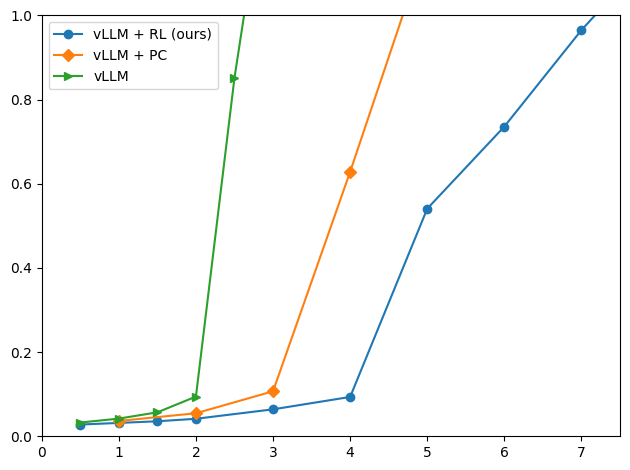

In [8]:
import matplotlib.pyplot as plt
import numpy as np

prefixlen_plot = 512
metric_plot = 'avg_per_output_token_latency'
# metric_plot = 'throughput'
line_styles = ['-o', '-D', '->']
reqrate_plot = [0.5, 1.0, 1.2, 1.5, 2.0, 2.2, 2.4, 2.5, 3.0, 4.0, 4.2, 4.8, 5.0, 6.0, 7.0, 7.5, 8.0] # set of values

condition = (df['prefixlen']==prefixlen_plot)
condition_dict = { 
    'vLLM + RL (ours)': condition & (df['relay']=='true'),
    'vLLM + PC': condition & (df['relay']=='promptcache'),  
    'vLLM': condition & (df['relay']=='false') 
}

data_dict = {}
for name, cond in condition_dict.items():
    # print(df)
    # print(df['reqrate'])
    view = df[cond].sort_values('reqrate')
    x = view['reqrate'].to_numpy(dtype=np.float32)
    y = view[metric_plot].to_numpy(dtype=np.float32)
    # print(x)
    mask = np.in1d(x, reqrate_plot)
    # print(mask)
    data_dict[name] = (x[mask], y[mask])


# plt_context = plt.style.context(['light', 'grid'])

import contextlib
plt_context = contextlib.nullcontext()

    
with plt_context:
    figure, ax = plt.subplots()
    for idx, (label, data) in enumerate(data_dict.items()):
        x, y = data
        ax.plot(x, y, line_styles[idx], label=label)
    ax.set_ylim((0, 1.0))
    ax.set_xlim((0, 7.5))
    ax.legend()
plt.tight_layout()
plt.show()